# Pittsburgh Food Deserts 🗺🥗🌵

I used a number of datasets from [WPRDC](http://www.wprdc.org/): 
- [Allegheny County Supermarkets & Convenience Stores](https://data.wprdc.org/dataset/allegheny-county-supermarkets-convenience-stores). A list of all supermarkets and convenience stores in Allegheny County, this dataset will be used to identify food deserts in the city.
- [SNAP census data](https://data.wprdc.org/dataset/neighborhoods-with-snap-data). This dataset provides a as well as shapefiles for easily visualizing the neighborhoods.
- [This dataset](https://data.wprdc.org/dataset/pgh) is useful for interpreting the obtuse naming scheme of the shapefile.

---
## 💻 Code

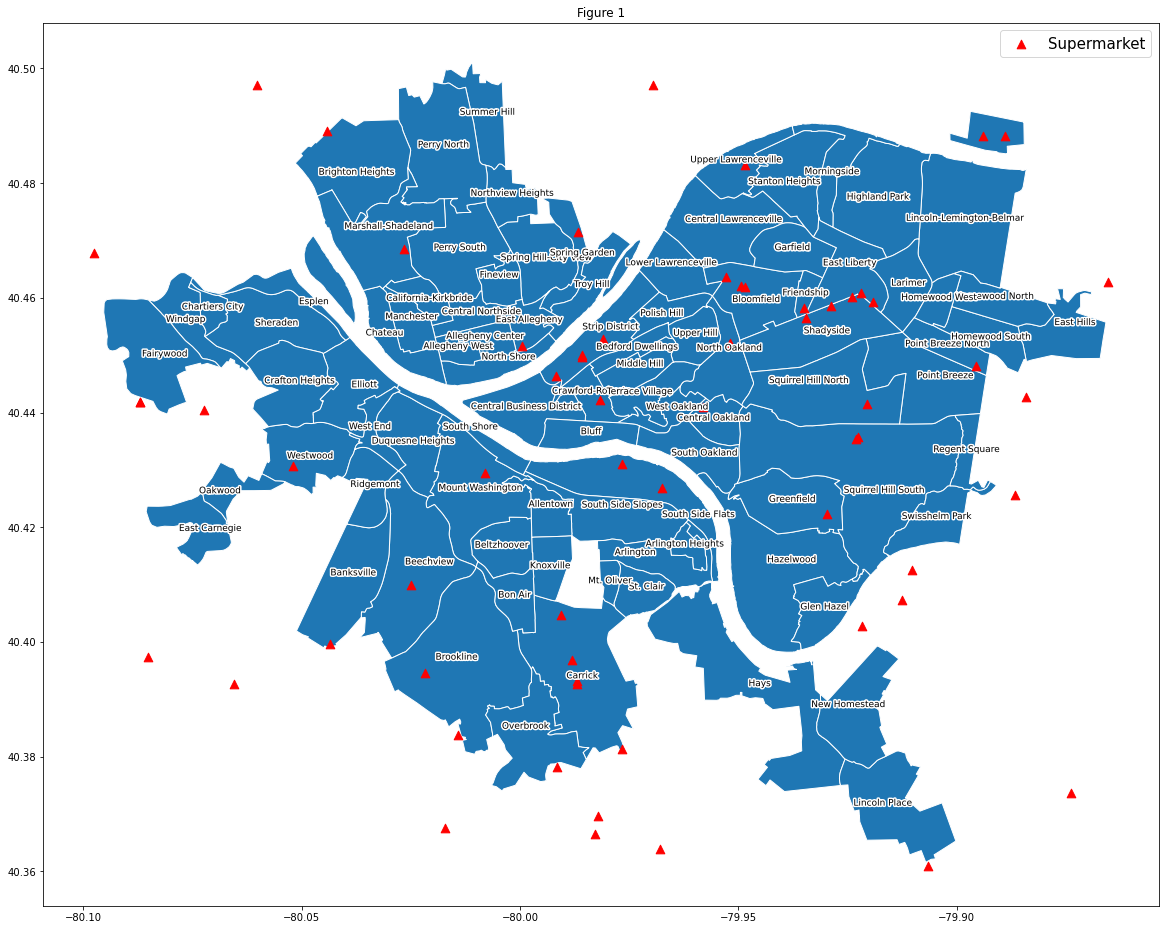

In [2]:
import pandas as pd
import geopandas as gpd
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patheffects as pe
from shapely.geometry import Point, Polygon

# read datasets
pgh_map = gpd.read_file("data/SNAP/Neighborhood_SNAP.shp") # map shapefile
pgh_data = pd.read_csv("data/SNAP/Neighborhoods_with_SNAP_Data.csv") # SNAP data
stores = pd.read_csv("data/conv-sm.csv") # supermarkets/convenience stores

# define PGH city lat/lon limits
north =  40.5
south =  40.36
east  = -80.1
west  = -79.86

## clean up data 
# filter out null coord data
stores = stores[stores['Lat'].notna() | stores['Lon'].notna()]
# limit to values within PGH city limits
stores.drop(stores[(stores['Lat'] >= north) | (stores['Lat'] < south)].index, inplace = True)
stores.drop(stores[(stores['Lon'] >= west) | (stores['Lon'] < east)].index, inplace = True)

# more usable column names
pgh_map['hood_name'] = pgh_map['Neighbor19']

# coordinate system
pgh_map['geometry'] = pgh_map['geometry'].to_crs(epsg=4326) # project map data to lat/lon
crs = 'epsg:4326' # define coordinate system (WGS84)
geometry = [Point(xy) for xy in zip(stores['Lon'],stores['Lat'])] # supermarket + convenience coords
geo_df = gpd.GeoDataFrame(stores, crs = crs, geometry = geometry)

# extract and append neighborhood labels
def label_map():
    pgh_map['coords'] = pgh_map['geometry'].apply(lambda x: x.representative_point().coords[:])
    pgh_map['coords'] = [coords[0] for coords in pgh_map['coords']]
    for idx, row in pgh_map.iterrows():
        plt.annotate(text = row['hood_name'], xy=row['coords'],
                     horizontalalignment='center', size=9, path_effects=[pe.withStroke(linewidth=3, foreground='white')])
        
# plot map
fig,ax = plt.subplots(figsize = (20,20)) # plot size
label_map() # neighborhood labels
pgh_map.plot(ax=ax, edgecolor='white') # map
plt.title('Pittsburgh') # title

# plot supermarkets
geo_df[geo_df['Category'] == 'Supermarket'].plot(ax = ax, markersize = 75, color = 'r', marker = '^', label = 'Supermarket') # pts
plt.legend(prop = {'size': 15}) # legend

---
## 🔎 Analysis
The map shows the locations of supermarkets on the map of Pittsburgh.

At the moment, this data only contains the latitude/longitude coordinates. A program can be written to determine what neighborhoods these supermarkets fall into based on the shapefile. Because the number of neighborhoods with supermarkets is limited, a measure of a neighborhood's _proximity_ to a supermarket can be used instead.

WPRDC also provides the locations of convenience stores and fast food restaurants. These datasets can be worked into a metric: supermarkets are a plus, fast food and convenience stores are a minus.